In [1]:
!pip install google_trans_new

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import google_trans_new

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hanjiatong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hanjiatong/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hanjiatong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hanjiatong/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [190]:
df = pd.read_csv('../../Datasets/cleaned_reviews.csv').iloc[:,1:]

In [191]:
df.head()

,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,host_since,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month
0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 2014) USD750 per month. You may want to take a look at room number 1 as well. Room NO 1 is available immediately at USD700 per month Its at the far right corner of your screen below. Please note that currency is in USD unless stated as SGD. only LONG TERM STAY (6 months minimum) Place is available only to adults. Good location. 10 minutes walk to train station. 10 minutes walk to Bus stops. 7 minutes walk to 24 hour food center. 7 minutes walk to...,NaN,266763,2010-10-20,...,94.0,10.0,10.0,10.0,10.0,8.0,8.0,f,2,0.02
1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo development. Everything was kept very clean and I had the use of my own bathroom. Sujatha and her husband are great hosts - very friendly and accommodating. I'll be staying here again.,Pleasant Room along Bukit Timah,"Fully furnished bedroom with a nice view on the 10th floor of a newly built private condominium on one of the most preferred residential estates in Singapore. Good Condition room, bright & windy. Comes with TV, Aircon, Bed, wardrobe. Can accommodate couples or 2 ladies or students for long-term rental only. Kitchen, washing facilities, gym, swimming pool, etc. We love to host people & have the opportunity to learn & enjoy the various culture & languages around the world. We hope to part as...","The serenity & quiet surrounding makes it an ideal place to come back to after work / play. Lovely birds chirping for a nice morning wake up (if you leave the windows open) are a pleasure to wake up to. Located on the main road but at just a short walk in makes it an ideal neighbourhood with excellent transport facilities & food, supermarket, etc, all as required for a convenient living.",227796,2010-09-08,...,91.0,9.0,10.0,10.0,10.0,9.0,9.0,f,1,0.30
2,15222393,50646,2014-06-05,Welli,"Stayed over at Sujatha's house for 3 good nights with my boyfriend. Sujatha and her husband are great hosts, very welcoming and friendly. The room is comfortable and clean. I'm happy to have my own bathroom as i'm particular with shared bathroom. \r\nThe location is accessible. A few minutes walk from the house to nearest bus stop which can bring you to town.\r\nGood place, good hosts, good price.\r\nHighly recommended!",Pleasant Room along Bukit Timah,"Fully furnished bedroom with a nice view on the 10th floor of a newly built private condominium on one of the most preferred residential estates in Singapore. Good Condition room, bright & windy. Comes with TV, Aircon, Bed, wardrobe. Can accommodate couples or 2 ladies or students for long-term rental only. Kitchen, washing facilities, gym, swimming pool, etc. We love to host people & have the opportunity to learn & enjoy the various culture & languages around the world. We hope to part as...","The serenity & quiet surrounding makes it an ideal place to come back to after work / play. Lovely birds chirping for a nice morning wake up (if you leave the windows open) are a pleasure to wake up to. Located on the main road but at just a short walk in makes it an ideal neighbourhood with excellent transport facilities & food, supermarket, etc, all as required for a convenient living.",227796,2010-09-08,...,91.0,9.0,10.0,10.0,10.0,9.0,9.0,f,1,0.30
3,5543172,50646,2014-07-02,Cyril,It's been a lovely stay at Sujatha's. The room is clean and the location is just perfect for a stop-over in Singapore. I really enjoyed relaxing at the swimmi

In [192]:
df.comments.isna().value_counts()

False    155521
True        176
Name: comments, dtype: int64

In [193]:
df.comments.fillna('',inplace=True)

In [194]:
df.comments[0]

'Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.'

### Clear some unprocessable comments
There are automated replies like _'the host canceled the reservation the day before arrival. This is an automated posting'_. Host cancellation has already been considered in the cleaned listing dataset. Thus we omit them here.

In [195]:
cancel_post = 'This is an automated posting'

df = df[[cancel_post not in text for text in df.comments]]

In [196]:
df.shape

(153109, 55)

#### Utility function: Detect foreign languages and translate them into English

In [197]:
from google_trans_new import google_translator 
translator = google_translator() 

def detectandtranslate(texts):
    trans = pd.DataFrame(index=texts.index,columns=['text'])
    non_eng_count = 0
    for i in texts.index:
        text = texts[i]
        detect_res = translator.detect(text)
        if not detect_res:
            trans.loc[i,'text'] = ''
        elif translator.detect(text)[1] != 'english':
            non_eng_count += 1
            trans.loc[i,'text'] = translator.translate(text,lang_tgt='en')
        else:
            trans.loc[i,'text'] = text
    return non_eng_count / len(texts), trans

### 1. Tokenize the text and extract most frequent words

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords

def tokenizer(text):
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    return(text)

vectorizer = TfidfVectorizer(stop_words='english',
                             ngram_range=(1,2),
                             max_df = 0.5,
                             tokenizer=tokenizer,
                             max_features=200)
X = vectorizer.fit_transform(df.comments)

In [199]:
print(vectorizer.get_feature_names())

['access', 'accommodating', 'air', 'airbnb', 'airport', 'amazing', 'amenities', 'apartment', 'area', 'available', 'away', 'awesome', 'bathroom', 'beautiful', 'bed', 'bedroom', 'best', 'better', 'big', 'bit', 'book', 'breakfast', 'building', 'bus', 'bus stop', 'center', 'central', 'centre', 'check', 'check-in', 'chinatown', 'city', 'clean', 'close', 'close mrt', 'come', 'comfortable', 'communication', 'condo', 'convenient', 'cozy', 'day', 'days', 'definitely', 'definitely recommend', 'distance', 'door', 'easily', 'easy', 'enjoyed', 'enjoyed stay', 'especially', 'exactly', 'excellent', 'experience', 'extremely', 'facilities', 'family', 'fantastic', 'far', 'fast', 'feel', 'felt', 'flat', 'floor', 'food', 'friendly', 'friends', 'gave', 'good', 'good location', 'good place', 'got', 'great', 'great host', 'great location', 'great place', 'great stay', 'guests', 'help', 'helpful', 'highly', 'highly recommend', 'highly recommended', 'home', 'host', 'hosts', 'hotel', 'house', 'it’s', 'kind', 'k

### 2. Using Vader Model
Reasons for choosing this model:<br>
1. From the NLTK package, Vadar model is trained with **website comments and reviews**, making itself suitable for this senario.
2. It is exceptionally good at dealing with **sentences with mixed sentiments** and rate a compounded score.
3. It accounts for many **acronyms, slangs, Capitalized Words and even emojis** that are recently prevalent on the Internet.
4. Rule-based model makes it **easily adjustable**.

In [200]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [201]:
sid = SentimentIntensityAnalyzer()
newWords = {'amenities': 0.5, 'big': 0.5, 'bus': 0.5,'near':0.5,'nearby':0.5,'quiet':0.5,'quick':0.5,'spacious':0.5,'responsive':0.5,
    'family':0.5,'close':0.5,'room clean':0.5,'hospitality':0.5,'accessible':0.5,'affordable':0.5,'high':0.5,'shopping':0.5,'dining':0.5,'exactly':0.5}
sid.lexicon.update(newWords)

In [202]:
def get_sentiment(text, sid):
    return sid.polarity_scores(text)['compound']

In [203]:
df['polarity_score'] = [get_sentiment(text,sid) for text in df.comments]
df['polarity_score'].describe()

count    153109.00000
mean          0.64358
std           0.39972
min          -0.99830
25%           0.44040
50%           0.83100
75%           0.94100
max           0.99980
Name: polarity_score, dtype: float64

<ipython-input-204-5efb92ba86a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['count'] = 1
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


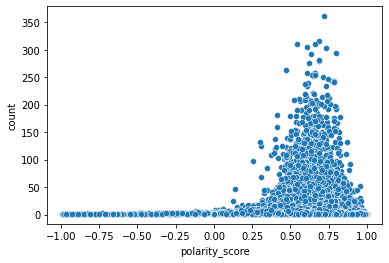

In [204]:
df_full = df[['polarity_score','listing_id']]
df_full['count'] = 1
df_full = df_full.groupby(['listing_id']).agg({'polarity_score':'mean', 'count':'count'})
sns.scatterplot('polarity_score', 'count', data=df_full);

In [205]:
df.loc[df.polarity_score >= 0.5,['reviewer_id','comments','polarity_score']].sample(20).style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])

,reviewer_id,comments,polarity_score
99684,147020442,Her place is good and very clean. Well maintained. Thank you Egem.,0.868000
24282,89630491,A fantastic location and we really enjoyed the local food spots that Cheryl suggested. We also really liked the fantastic pool.,0.931100
75266,129184510,Very clean and comfortable apartment at a upscale complex at a very central east coast area location. Clear and concise instructions were given for check-in and all questions were answered promptly. Highly recommended.,0.882000
72762,21194653,Very accurate according to description. Great location with dining options a walk away. Friendly area. Would recommended her place.,0.862500
35071,1424380,Jerry’s place is very clean and nice. My baby and me had a god sleep.,0.799600
137118,45826069,The place is maybe better that a dormitory hostel because you can have your own private space. However I found that it was dirty and smelly and very difficult to bear with this for more than 1 night. The locker in the room was very uncomfortable for someone carrying a luggage but had to use it because the room can't be closed from outside. Nevertheless Faizal was very helpful and kind and the neighborhood is very nice. I would say staff and location are the tops of this accommodation.,0.950800
43768,44717517,Great location,0.624900
110701,4031092,"My teammates and I had a wonderful time at Pinggi's apartment. It is in such a great location there is food, drinks, shopping (Mustafa) and subway in a walk distance. The apartment its self is comfortable, simple and neat. Pinggi is a wonderful host responding promptly to all queries, and very helpful. I would definitely recommend this apartment.",0.979600
87631,78147036,Nice boutique hostel with good location,0.690800
153197,310823503,Great place for a getaway. Suffice space to cook and enjoy the space,0.807400


In [206]:
df.loc[df.polarity_score == 0,['reviewer_id','comments','polarity_score']].sample(20).style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])

,reviewer_id,comments,polarity_score
53115,133995773,"距離小印度站約10分鐘,房間有點小,淋浴處的排水系統有點問題,洗澡回有積水情形,但整體來說還可以",0.000000
94831,165995511,"春节期间到访住了三个晚上｡先说优点:交通地理位置极佳｡楼下100米就是Downtown Line地铁站,步行到武吉士地铁站也不算太远｡楼下对面有一个大众化的购物中心,过马路即到,可以买拖鞋短裤等日常用品｡餐厅更是数不胜数,楼下大排档好几间,隔壁楼电器城负一楼就是大食肆,从早餐到晚餐统统可以解决,楼对面200米内还有熟食中心,这个位置吃饭简直太方便｡整套公寓外部环境尚可,也足够安全｡ 再说缺点:室内面积不大,两房一厅,每个房间都不大,客厅也不大｡ (Hidden by Airbnb) 很多,放置食物在桌上,一会就来了很多 (Hidden by Airbnb) ｡床上用品比较陈旧,而且显得不够干净｡书柜的层板是坏的｡非常不满意的两点,洗手间马桶尺寸偏小;淋浴器水流非常小,就像挤牙膏,洗澡洗得很尴尬｡厨房提供碗盘和碟子,也有抽油烟机和煤气灶,可是居然没有炒菜的锅和铲｡住民宿就是要烹饪,但这里不能满足中餐的烹饪需求｡房间没有提供220V的转换插头,要自备｡没有拖鞋,要自备｡",0.000000
93355,95384456,"离小印度地铁口非常近,步行不到5分钟,早餐自己做来吃,可口而且方便｡房东还帮忙安排了接送机｡十分感谢,期待下次相聚",0.000000
16962,196619591,Boa relação qualidade-preço,0.000000
138245,155083534,"已经第三次入住了,房间够大,可以简单煮食,有洗衣机,解决我每天的洗衣问题,每星期三次的服务搞房间卫生,都很干净,出行也方便,满意的入住全程｡",0.000000
76058,159084902,"整洁､干净,房间也很大,一下楼就是牛车水地铁,非常方便｡",0.000000
73396,80117276,"Апартаменты расположены в кондоминимуме в центре Сингапура (в начале торговой улицы Орчард роад). Район классный. Бассейн на крыше - сказка. Персонал - пять звезд. Планировали снять квартиру, а получили еще и ежедневную уборку, завтрак и ресепшн.",0.000000
25609,59892978,記得自備面紙或在當地超市買!,0.000000
70556,162995185,"這次我們有三個大人跟兩個小小孩入住, 一間主臥室內有一張雙人床 外面客廳有一張沙發床,房東可另外提供床墊 有冰箱, 洗衣機, 瓦斯爐很方便 浴室是淋浴間 離花拉公園地鐵站很近, 只要走路2~3分鐘 離慕達發商場很近, 走路五分鐘左右 提供自助入住, 很方便",0.000000
151063,47987050,Room is cosy!,0.000000


There are many **non-english comments** that received **inaccurate scores**.

In [207]:
df[df.polarity_score == 0].shape[0]

22475

We discard the posts with neutral sentiments as majority of them were written in foreign languages or not meaningful. 

In [208]:
df_eng = df[df.polarity_score != 0]

In [209]:
df_eng.loc[df_eng.polarity_score <= -0.5,['reviewer_id','comments','polarity_score']].sample(20).style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])


,reviewer_id,comments,polarity_score
100418,87141044,The place is situated about 5 minutes from Boon Keng MRT station and was convenient. For westerners the local shops are limited with young children but that was fine. Room was reasonable and reflective of price in comparison to local options. Singapore is just expensive. Did not use kitchen so no commentary offered. Bathrooms are small but very good showers and bedrooms ample for sure. One minor criticism and it is minor is tv is very small and choice poor as no cable. This was not a problem but with no DVD and young children meaning early nights could be an issue for some.,-0.859800
67088,188870943,"半夜凌晨到房源門口引文他鑰匙放在門外的保險箱要密碼打開拿鑰匙｡他給了錯的密碼 電話 和 (Hidden by Airbnb) ID 根本打不開聯繫不上人 還要吵醒別的訪客幫忙開門 別的訪客也說他們昨天入住也說遇到這個情況 要求退回一晚的費還被房東說幼稚 最後說要退一半也是沒退回 也不回 In the middle the night I arrived and I try to get keys to into the house but the strongbox outside the door within keys can’t open cuz the owner gives the wrong password ,I stand outside the door for 2 hours. Finally, I woke up other visitors by knocking on the door and they help me to open the door. The owner gives the wrong phone number and The (Hidden by Airbnb) ID was wrong too, I could not find her . Other visitor said they have same situation too. And I said you need to refund me a night price, the owner just said you are childish and didn’t refund me",-0.880700
108824,112634551,"Die Lage der Unterkunft ist ideal. Man ist schnell am River oder in der anderen Richtung an der Shopping Meile (beides circa 10-15min Fusswalk). Die Unterkunft liegt direkt an einer Hauptverkehrsstrasse und somit ist es wirklich sehr laut. Im Grunde hat die Unterkunft alles was man für 1-2 Nächte braucht. Leider roch es im Zimmer sehr muffig (Schimmel und Rauch). Das Bettlaken hatte gelbe Flecken und die Matratze roch auch stickig und nass. Im Badezimmer ist etwas Schimmel am Waschbecken, da das Bad auch kein Fenster hat. Das Badezimmer ist sehr eng und klein. Für eine Nacht dürfte das alles zu ertragen sein. Länger hätten wir aber nicht bleiben wollen",-0.945100
104153,110390149,"Personally i wouldnt recommend staying here. We had a terrible experience. First, we were not informed that there will be extra fees for children ages 2-4 years old. We also had to pay for luggages storage for an hour. Everthing was not clarrified before our arrival. And the worst part was the day we had to leave we found out that we were locked from outside. Someone must have locked it or the locked was damaged. Regarless, were not able to open it from inside. We were so scared and worried that we wouldnt make it on our flight on time. Not to mention that we were in a diffrent country and we have kids with us. Not really knowing whats going on. If there was a fire or accident, there was no way of us getting out of that building. Doors were locked and windows was padlocked as well. They dont even have fire exit! We will not come back to this place again!",-0.979000
20735,154117638,"Nossa estadia no espaço de Lux foi ótima. A cozinha está equipada conforme a descrição e as fotos, com itens básicos para o dia a dia. A sala é confortável, o quarto é espaçoso e a cama é ótima. Tem piscina e academia. O check in foi ótimo e no horário combinado. O espaço fica próximo do trem. Eu indico o espaço, pois estava tudo ótimo.",-0.526700
79605,88447785,"Das Zimmer war sauber und mit eigener Dusche. Die nächste Bahnstation war in ca 24 min zu Fuß zu erreichen, der Bus schneller. Wir konnten auf Nachfrage sogar Wäsche waschen, es hat alles problemlos geklappt! Das Preis-Leistungsverhältnis ist super. Das war ein schöner Aufenthalt, sehr zu empfehlen.",-0.909800
109702,42760661,"On the way from the airport to the host's address, I saw the message from the host that the place I booked had issues, and I was asked to go to a hotel. The hotel while located in the middle of Little India is a seedy place that is extremely unclean with walls that have 1/2 inch cracks from which your room is filled wit

Some of extremely negative posts were **not written in English**.<br>
So let's **translate them back into English** and **reassign them the sentiment score**.

In [211]:
non_english_portion, translated_text = detectandtranslate(df_eng.comments[(df_eng.polarity_score <= -0.95)])

google_new_transError: 429 (Too Many Requests) from TTS API. Probable cause: Unknown

In [ ]:
print('{0:.2f}% of the texts are non-english\n'.format(non_english_portion*100))

In [ ]:
for ind in df_eng[df_eng.polarity_score <= -0.95].index:
    df_eng.comments[ind] = translated_text.text[ind]
    df_eng.polarity_score[ind] = get_sentiment(translated_text.text[ind],sid)

In [ ]:
sns.distplot(df_eng['polarity_score'], norm_hist=True, color='g')
plt.title('Distribution of sentiment polarity');

In [ ]:
def getsentiment(score):
    if score>=0:
        return 'pos'
    else:
        return 'neg'
df_eng['sentiment'] = df_eng['polarity_score'].apply(getsentiment)

In [ ]:
df_eng['sentiment'].value_counts().plot(kind='bar')

In [ ]:
df_eng.to_csv('../../Datasets/cleaned_senti_reviews.csv')